**imports**

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean, median
from sklearn.model_selection import train_test_split
import keras,os
import numpy as np
import random
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D,BatchNormalization,Lambda,ZeroPadding2D,Concatenate
from keras.applications import ResNet50,VGG16, xception ,inception_resnet_v2, NASNetLarge,Xception,VGG19,ResNetRS152,inception_v3,vgg16,resnet_v2,ResNet50V2
from keras.models import Sequential,Model
from sklearn.metrics import classification_report, confusion_matrix
from scipy.fftpack import fft, ifft
from scipy import signal
import tensorflow as tf
tf.version
from keras.optimizers import Adam
import torch
import torchaudio.transforms as T


**pathes**

In [ ]:
healthy_path = '/content/drive/MyDrive/#GradProject/Project Data/Healthy'
pathology_path= '/content/drive/MyDrive/#GradProject/Project Data/pathology'

**helpur fuction**

In [ ]:
def get_the_first_second(signal):
  # Extract the one-second window
  one_sec_window = signal[:22050]
  # Print the shape of the one-second window array
  return one_sec_window


def get_the_middle_second(signal):
  midpoint = len(signal) // 2
  start = midpoint - 22050 // 2
  end = midpoint + 22050 // 2
  # Extract the one-second window
  one_sec_window = signal[start:end]
  # Print the shape of the one-second window array
  return one_sec_window


def get_the_last_second(signal):
  # Extract the one-second window
  one_sec_window = signal[-22050:]
  # Print the shape of the one-second window array
  return one_sec_window

# Calculate the frame length and frame shift in samples
def framing_thesignal(signal):
    frame_length = int(0.04 * sr)
    frame_shift = int(0.02 * sr)
    # Calculate the total number of frames in the signal
    num_frames = int(np.ceil(len(signal) / frame_shift))
    # Pad the signal with zeros to ensure that there are enough samples
    # for the last frame
    pad_length = num_frames * frame_shift - len(signal)
    signal= np.pad(signal, (0, pad_length), 'constant', constant_values=0)
    # Use a sliding window to extract each frame
    frames = []
    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        frame = signal[start:end]
        frames.append(frame)
    # Apply a window function to each frame to reduce spectral leakage
    window = np.hamming(num_frames)
    frames = np.array(frames)
    frames *= window
    return frames



def cocatenate_and_applay_fft(frames):
  the_signal=[]
  for i in range(len(frames)):
    X = np.fft.fft(frames[i])
    magnitude_spectrum = np.abs(X)
    the_signal=np.concatenate((the_signal,magnitude_spectrum),axis=0)
  return the_signal



def extract_mell_spectogram(signalm):
  mel_specto=librosa.feature.melspectrogram(y=signalm,sr=22050)
  delta_mel_specto=librosa.feature.delta(mel_specto)
  delta2_mel_specto=librosa.feature.delta(delta_mel_specto,order=2)
  comrehensive_mel_specto=np.concatenate((mel_specto,delta_mel_specto,delta2_mel_specto))
  return comrehensive_mel_specto

def extract_mfcc(signalm):
  mfcc=librosa.feature.mfcc(y=signalm,n_mfcc=13,sr=22050)
  delta_mfcc=librosa.feature.delta(mfcc)
  delta2_mfcc=librosa.feature.delta(delta_mfcc,order=2)
  comrehensive_mfccs=np.concatenate((mfcc,delta_mfcc,delta2_mfcc))
  return comrehensive_mfccs


def freq_mask(spec, F=10, num_masks=1):
    test = spec.clone()
    num_mel_channels = test.shape[1]
    if(num_mel_channels>F):
      F = F
    else:
      F = 25
    for i in range(0, num_masks):
      freq = random.randrange(0, F)
      zero =  random.randrange(0,num_mel_channels- freq)
      # avoids randrange error if values are equal and range is empty
      if (zero == zero + freq): return test
      mask_end = random.randrange(zero, zero + freq)
      test[0][zero:mask_end] = test.mean()
    return test


def time_mask(spec, time=40, num_masks=1):
    test = spec.clone()
    length = test.shape[0]
    if(length>time):
      time = time
    else:
      time = 40
    for i in range(0, num_masks):
        t = random.randrange(0, time)
        zero = random.randrange(0, length - t)
        if (zero == zero + t): return test
        mask_end = random.randrange(zero, zero + t)
        test[0][:,zero:mask_end] = test.mean()
    return test

def pitchshift(signal,sr,n):
  signal=signal.reshape(33024,)
  augmented=librosa.effects.pitch_shift(y=signal,sr=sr,n_steps=n)
  augmented=augmented.reshape(384,86)
  return augmented


In [ ]:
healthy_spectogram=[]
patholgy_spectogram=[]

**preprocessing and feature extraction**

In [ ]:
i=0
for audio in os.listdir(healthy_path):
        audio_path= os.path.join(healthy_path, audio)
        if audio_path.__contains__('phrase'):
          if(i==400):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          healthy_spectogram.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1
i=0
for audio in os.listdir(pathology_path):
        audio_path= os.path.join(pathology_path, audio)
        if audio_path.__contains__('phrase'):
          if(i==834):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          patholgy_spectogram.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1



<ipython-input-3-fb3374274765>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.array(frames)
<ipython-input-3-fb3374274765>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.array(frames)


In [ ]:
i=0
for audio in os.listdir(healthy_path):
        audio_path= os.path.join(healthy_path, audio)
        if audio_path.__contains__('iau'):
          if(i==400):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          healthy_spectogram.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1
i=0
for audio in os.listdir(pathology_path):
        audio_path= os.path.join(pathology_path, audio)
        if audio_path.__contains__('iau'):
          if(i==834):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          patholgy_spectogram.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1


<ipython-input-3-fb3374274765>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.array(frames)


In [ ]:
valdetion_healthy=[]
valdetion_pathology=[]
i=400
for audio in os.listdir(healthy_path):
        audio_path= os.path.join(healthy_path, audio)
        if audio_path.__contains__('iau'):
          if(i==687):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          valdetion_healthy.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          #valdetion_healthy.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(get_the_middle_second(y)))))
          #valdetion_healthy.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(get_the_last_second(y)))))
          i=i+1
i=834
for audio in os.listdir(pathology_path):
        audio_path= os.path.join(pathology_path, audio)
        if audio_path.__contains__('iau'):
          if(i==1121):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          valdetion_pathology.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          #valdetion_pathology.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(get_the_middle_second(y)))))
          #valdetion_pathology.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(get_the_last_second(y)))))
          i=i+1

<ipython-input-3-fb3374274765>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.array(frames)


In [ ]:
i=400
for audio in os.listdir(healthy_path):
        audio_path= os.path.join(healthy_path, audio)
        if audio_path.__contains__('phrase'):
          if(i==634):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          valdetion_healthy.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1
i=834
for audio in os.listdir(pathology_path):
        audio_path= os.path.join(pathology_path, audio)
        if audio_path.__contains__('phrase'):
          if(i==1068):
            break;
          y,sr=librosa.load(audio_path,duration=1)
          valdetion_pathology.append(extract_mell_spectogram(cocatenate_and_applay_fft(framing_thesignal(y))))
          i=i+1

<ipython-input-3-fb3374274765>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames = np.array(frames)


In [ ]:
print(len(healthy_spectogram))
print(len(patholgy_spectogram))

800
1668


**data augmantation**

In [ ]:
for i in range(868):
  healthy_spectogram.append(np.array(freq_mask(torch.tensor(healthy_spectogram[i]))))

In [ ]:
print(len(healthy_spectogram))
print(len(patholgy_spectogram))
print(len(valdetion_healthy))
print(len(valdetion_pathology))

1668
1668
521
521


**prepare and train test splite**

In [ ]:
healthy_spectogram=np.array(healthy_spectogram)
patholgy_spectogram=np.array(patholgy_spectogram)
valdetion_healthy=np.array(valdetion_healthy)
valdetion_pathology=np.array(valdetion_pathology)

In [ ]:
healthy_spectogram= np.repeat(healthy_spectogram[..., np.newaxis], 1, -1)
print(healthy_spectogram.shape)

patholgy_spectogram= np.repeat(patholgy_spectogram[..., np.newaxis], 1, -1)
print(patholgy_spectogram.shape)

valdetion_healthy= np.repeat(valdetion_healthy[..., np.newaxis], 1, -1)
print(valdetion_healthy.shape)

valdetion_pathology= np.repeat(valdetion_pathology[..., np.newaxis], 1, -1)
print(valdetion_pathology.shape)

(1668, 384, 86, 1)
(1668, 384, 86, 1)
(521, 384, 86, 1)
(521, 384, 86, 1)


In [ ]:
healthy_label=[]
pathology_label=[]
for i in range(1668):
  healthy_label.append(0)
for i in range(1668):
  pathology_label.append(1)

In [ ]:
valdition_healthy_label=[]
valdation_pathology_label=[]
for i in range(521):
  valdition_healthy_label.append(0)
for i in range(521):
  valdation_pathology_label.append(1)

In [ ]:
from pandas.compat import numpy
from numpy.core import numerictypes

train=[]
test=[]

for i in range(len(healthy_spectogram)):
  train.append([healthy_spectogram[i],healthy_label[i]])

for i in range(len(patholgy_spectogram)):
  train.append([patholgy_spectogram[i],pathology_label[i]])


for i in range(len(valdetion_healthy)):
  test.append([valdetion_healthy[i],valdition_healthy_label[i]])

for i in range(len(valdetion_pathology)):
  test.append([valdetion_pathology[i],valdation_pathology_label[i]])

random.shuffle(train)
random.shuffle(test)



In [ ]:
X_train=[]
y_train =[]
X_valid = []
y_valid =[]
for i in range(len(train)):
  X_train.append(train[i][0])
  y_train.append(train[i][1])
for i in range(len(test)):
  X_valid.append(test[i][0])
  y_valid.append(test[i][1])


In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

3336
3336
1042
1042


In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_valid=np.array(X_valid)
y_valid=np.array(y_valid)

In [ ]:
X_validate,X_test,y_validate,y_test= train_test_split(X_valid,y_valid,test_size=0.5,random_state=134,shuffle=True)

In [ ]:
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)

(521, 384, 86, 1)
(521,)
(521, 384, 86, 1)
(521,)


**modelt**

In [ ]:
Optimizer = keras.optimizers.SGD(learning_rate=0.01,momentum = 0.5)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = Sequential([ResNet50(include_top=False,pooling='max',weights=None,input_shape=(X_train.shape[1],X_train.shape[2],1)),
                    Dense(1, activation='sigmoid') ])
model.compile(optimizer=Optimizer, loss='binary_crossentropy', metrics=['accuracy'])

**train**

In [ ]:
batch_size=10
epochs=30
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_validate,y_validate),verbose=1)

Epoch 1/30
334/334 [==============================] - 35s 103ms/step - loss: 0.1047 - accuracy: 0.9634 - val_loss: 0.2522 - val_accuracy: 0.9770
Epoch 2/30
334/334 [==============================] - 32s 97ms/step - loss: 0.0886 - accuracy: 0.9706 - val_loss: 0.1935 - val_accuracy: 0.9750
Epoch 3/30
334/334 [==============================] - 33s 97ms/step - loss: 0.0835 - accuracy: 0.9724 - val_loss: 0.7860 - val_accuracy: 0.9616
Epoch 4/30
334/334 [==============================] - 33s 98ms/step - loss: 0.0666 - accuracy: 0.9784 - val_loss: 0.1293 - val_accuracy: 0.9808
Epoch 5/30
334/334 [==============================] - 34s 100ms/step - loss: 0.0641 - accuracy: 0.9796 - val_loss: 0.0590 - val_accuracy: 0.9923
Epoch 6/30
334/334 [==============================] - 33s 98ms/step - loss: 0.0529 - accuracy: 0.9820 - val_loss: 0.1060 - val_accuracy: 0.9866
Epoch 7/30
334/334 [==============================] - 34s 103ms/step - loss: 0.0418 - accuracy: 0.9865 - val_loss: 0.3155 - val_accura

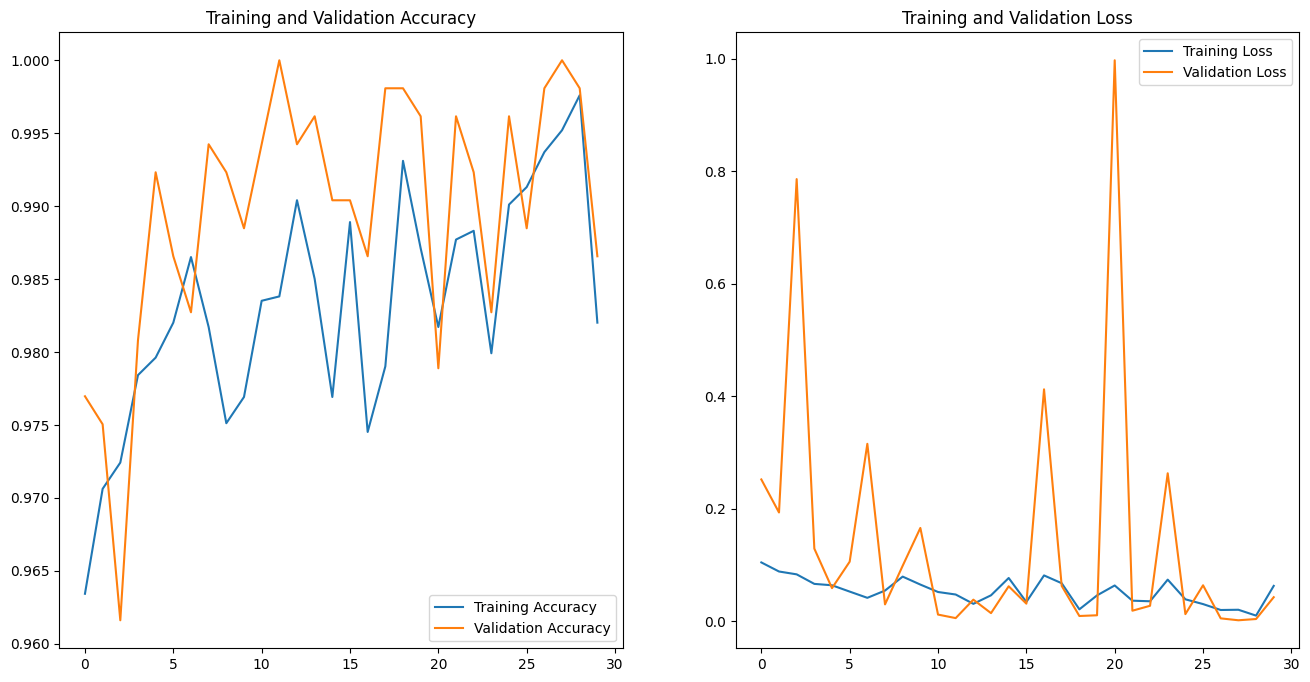

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss =  history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**test**

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)
print(classification_report(y_test, y_pred))

17/17 [==============================] - 1s 69ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       259
           1       0.99      0.98      0.99       262

    accuracy                           0.99       521
   macro avg       0.99      0.99      0.99       521
weighted avg       0.99      0.99      0.99       521



<Axes: >

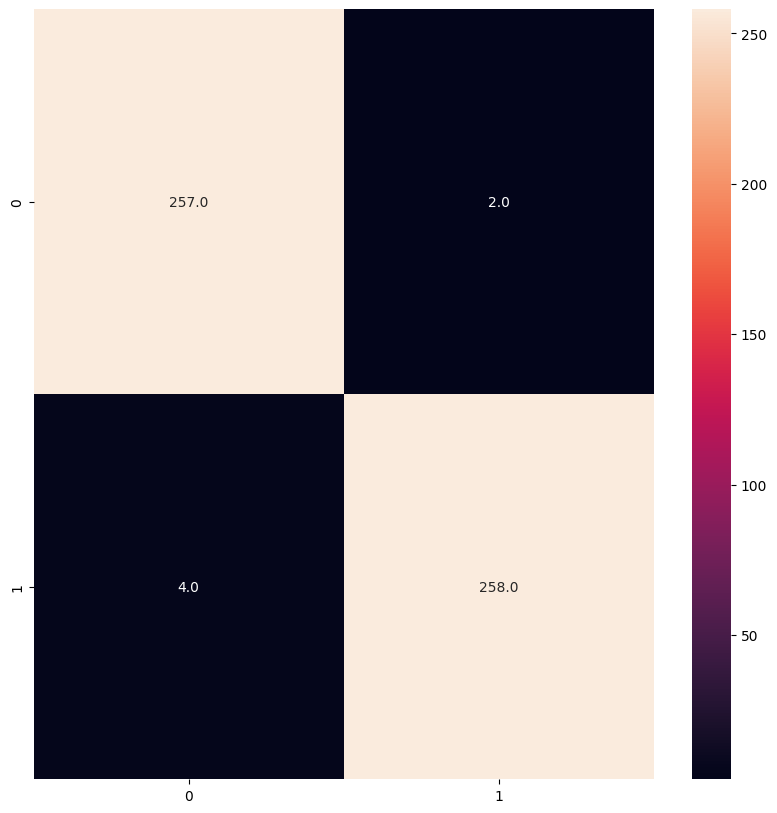

In [ ]:
matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(10,10))
sn.heatmap(matrix, annot = True, annot_kws={"size": 10}, fmt = '.1f')